In [1]:
import pandas as pd
import numpy as np

def generate_mock_metadata(n=100):
    return pd.DataFrame({
        'filename': [f'file_{i}.txt' for i in range(n)],
        'access_freq': np.random.rand(n),                # 0 to 1
        'size_MB': np.random.uniform(0.1, 10.0, n),     #size
        'last_accessed': np.random.rand(n),              
        'tier': np.random.choice(['hot', 'warm', 'cold'], n) 
    })

metadata_df = generate_mock_metadata()
metadata_df.head()


,filename,access_freq,size_MB,last_accessed,tier
0,file_0.txt,0.700360,4.202464,0.989843,cold
1,file_1.txt,0.827731,1.795191,0.523172,warm
2,file_2.txt,0.593495,2.790076,0.313168,warm
3,file_3.txt,0.883698,6.983353,0.770712,warm
4,file_4.txt,0.161962,2.352860,0.805919,warm


In [ ]:
#  reward logic RL logic 
def calculate_reward(row, target_tier):
    access = row['access_freq']
    size = row['size_MB']
    
    if target_tier == 'hot':
        reward = (1.0 * access) - (0.2 * size)
    elif target_tier == 'warm':
        reward = (0.6 * access) - (0.1 * size)
    else:  # cold
        reward = (0.2 * access) - (0.05 * size)
    
    return round(reward, 3)

# simulated metadata for preview
metadata_df['simulated_reward'] = metadata_df.apply(
    lambda row: calculate_reward(row, row['tier']), axis=1
)

metadata_df.head()


,filename,access_freq,size_MB,last_accessed,tier,simulated_reward
0,file_0.txt,0.367682,4.825134,0.712104,cold,-0.168
1,file_1.txt,0.901288,4.567915,0.423040,hot,-0.012
2,file_2.txt,0.858741,7.620647,0.129935,cold,-0.209
3,file_3.txt,0.146678,2.335805,0.204392,warm,-0.146
4,file_4.txt,0.659639,1.580072,0.256290,warm,0.238


In [4]:
# 3 tier options
TIER_OPTIONS = ['hot', 'warm', 'cold']

# Find the best tier (with max reward) for each file
def best_tier(row):
    rewards = {
        tier: calculate_reward(row, tier) for tier in TIER_OPTIONS
    }
    best = max(rewards, key=rewards.get)
    return best

# Create a new column with the agent's decision
metadata_df['recommended_tier'] = metadata_df.apply(best_tier, axis=1)

# Preview the result
metadata_df[['filename', 'access_freq', 'size_MB', 'tier', 'recommended_tier']]


,filename,access_freq,size_MB,tier,recommended_tier
0,file_0.txt,0.367682,4.825134,cold,cold
1,file_1.txt,0.901288,4.567915,hot,warm
2,file_2.txt,0.858741,7.620647,cold,cold
3,file_3.txt,0.146678,2.335805,warm,cold
4,file_4.txt,0.659639,1.580072,warm,hot
...,...,...,...,...,...
95,file_95.txt,0.100070,4.728551,cold,cold
96,file_96.txt,0.927611,8.777636,warm,cold
97,file_97.txt,0.255830,2.256307,warm,cold
98,file_98.txt,0.094739,1.122439,hot,cold


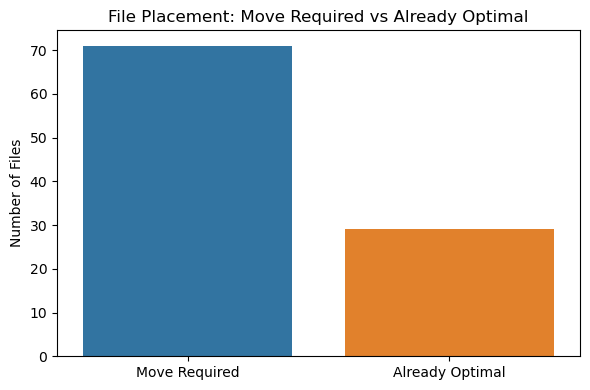

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a "needs_movement" flag
metadata_df['needs_movement'] = metadata_df['tier'] != metadata_df['recommended_tier']

# Count how many need to be moved vs already optimal
movement_summary = metadata_df['needs_movement'].value_counts().rename({True: 'Move Required', False: 'Already Optimal'})

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=movement_summary.index, y=movement_summary.values, hue=movement_summary.index, legend=False)
plt.title("File Placement: Move Required vs Already Optimal")
plt.ylabel("Number of Files")
plt.xlabel("")
plt.tight_layout()
plt.show()



📊 Movement Matrix:


recommended_tier,cold,hot,warm
tier,,,
cold,0,4,5
hot,21,0,9
warm,25,7,0


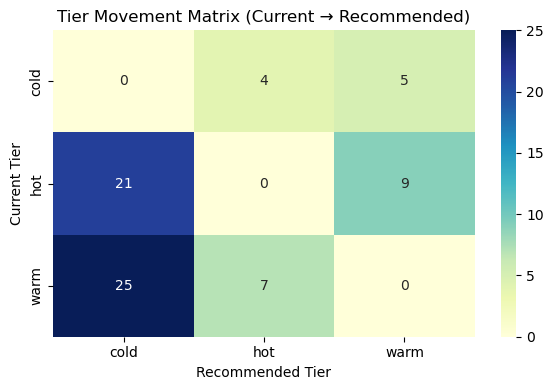

In [8]:
# Filter only files that need to move
movement_df = metadata_df[metadata_df['needs_movement']]

# Count transitions: from → to
transition_counts = movement_df.groupby(['tier', 'recommended_tier']).size().unstack(fill_value=0)

# Display transition table
print("📊 Movement Matrix:")
display(transition_counts)

# Optional: heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(transition_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Tier Movement Matrix (Current → Recommended)")
plt.ylabel("Current Tier")
plt.xlabel("Recommended Tier")
plt.tight_layout()
plt.show()


In [9]:
import os

BASE_PATH = "data"
TIER_FOLDERS = {
    "hot": os.path.join(BASE_PATH, "hot"),
    "warm": os.path.join(BASE_PATH, "warm"),
    "cold": os.path.join(BASE_PATH, "cold"),
}

# Create folders if they don’t exist
for folder in TIER_FOLDERS.values():
    os.makedirs(folder, exist_ok=True)

print("✅ Tier folders created:", TIER_FOLDERS)


✅ Tier folders created: {'hot': 'data\\hot', 'warm': 'data\\warm', 'cold': 'data\\cold'}


In [11]:
for _, row in metadata_df.iterrows():
    current_tier = row['tier']
    filename = row['filename']
    file_path = os.path.join(TIER_FOLDERS[current_tier], filename)
    
    # Write a small dummy file
    with open(file_path, 'w') as f:
        f.write("mockdata")  # 8 bytes only


In [12]:
import shutil

moved_count = 0

for _, row in metadata_df.iterrows():
    src_tier = row['tier']
    dst_tier = row['recommended_tier']
    filename = row['filename']

    if src_tier != dst_tier:
        src_path = os.path.join(TIER_FOLDERS[src_tier], filename)
        dst_path = os.path.join(TIER_FOLDERS[dst_tier], filename)

        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)
            moved_count += 1

print(f"✅ Moved {moved_count} files to new tiers based on agent's decision.")


✅ Moved 71 files to new tiers based on agent's decision.


In [13]:
from collections import defaultdict

# Dictionary to store movement counts and files
move_map = defaultdict(list)

# Track exact movements
for _, row in metadata_df.iterrows():
    src_tier = row['tier']
    dst_tier = row['recommended_tier']
    filename = row['filename']

    if src_tier != dst_tier:
        move_map[(src_tier, dst_tier)].append(filename)

# Convert to summary table
movement_summary = {
    f"{src} → {dst}": len(files) for (src, dst), files in move_map.items()
}

# Display the transition summary
print("📦 Movement Summary (File Count):")
for move, count in movement_summary.items():
    print(f"{move}: {count} files")

# Optional: display full table
import pandas as pd
transition_df = pd.DataFrame.from_dict(movement_summary, orient='index', columns=["File Count"])
transition_df


📦 Movement Summary (File Count):
hot → warm: 9 files
warm → cold: 25 files
warm → hot: 7 files
hot → cold: 21 files
cold → hot: 4 files
cold → warm: 5 files


,File Count
hot → warm,9
warm → cold,25
warm → hot,7
hot → cold,21
cold → hot,4
cold → warm,5


C:\Users\sarth\AppData\Local\Temp\ipykernel_21312\343103192.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\sarth\AppData\Local\Temp\ipykernel_21312\343103192.py:15: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sarth\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


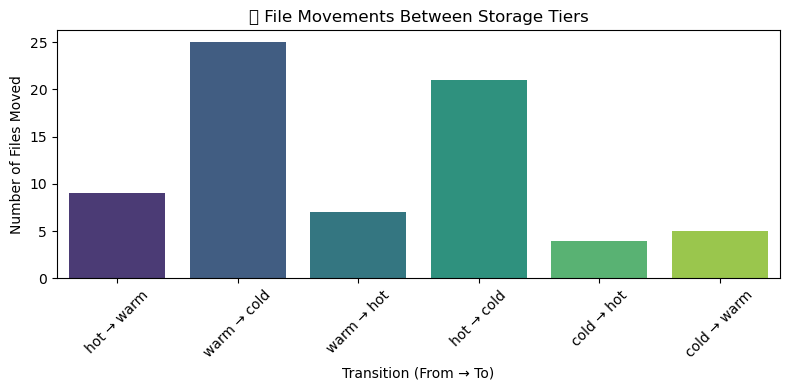

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create bar plot from movement summary
plt.figure(figsize=(8, 4))
sns.barplot(
    x=list(movement_summary.keys()),
    y=list(movement_summary.values()),
    palette="viridis"
)
plt.title("📦 File Movements Between Storage Tiers")
plt.ylabel("Number of Files Moved")
plt.xlabel("Transition (From → To)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [22]:
pip install stable-baselines3


  Using cached stable_baselines3-2.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached gymnasium-1.2.0-py3-none-any.whl.metadata (9.9 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached stable_baselines3-2.7.0-py3-none-any.whl (187 kB)
Using cached gymnasium-1.2.0-py3-none-any.whl (944 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   - -------------------------------------- 8.4/216.1 MB 47.2 MB/s eta 0:00:05
   - -------------------------------------- 9.7/216.1 MB 24.1 MB/s eta 0:00:09
   -- ------------------------------------- 11.0/216.1 MB 18.1 MB/s eta 0:00:12
   -- ------------------------------------- 12.3/216.1 MB 15.1 MB/s eta 0:00:14
   -- ------------------------------------- 13.9/216.1 MB 13.4 MB/s eta 0:00:16
   -- ------------------------------------- 15.2/216.1 MB 12.3 MB/s eta 0:00:17
   -- ------------------------------------- 16.0/216.1 MB 11.3 MB/s eta 0:00:18
   --- --------------------------

In [23]:
!pip install gym


In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class StorageEnv(gym.Env):
    def __init__(self, metadata_df):
        super(StorageEnv, self).__init__()
        
        self.metadata = metadata_df.copy().reset_index(drop=True)
        self.metadata[['access_freq', 'size_MB', 'last_accessed']] = self.metadata[['access_freq', 'size_MB', 'last_accessed']].apply(
            lambda x: (x - x.min()) / (x.max() - x.min()))
        
        self.index = 0
        
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)  # 0=hot, 1=warm, 2=cold

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.index = 0
        return self._get_obs(), {}

    def step(self, action):
        row = self.metadata.iloc[self.index]
        reward = self._calculate_reward(row, action)
        
        self.index += 1
        terminated = self.index >= len(self.metadata)
        truncated = False
        next_obs = self._get_obs() if not terminated else np.zeros(3, dtype=np.float32)
        
        return next_obs, reward, terminated, truncated, {}

    def _get_obs(self):
        row = self.metadata.iloc[self.index]
        return np.array([row['access_freq'], row['size_MB'], row['last_accessed']], dtype=np.float32)

    def _calculate_reward(self, row, action): #dynamic reward logic
        access = row['access_freq']
        size = row['size_MB']
        
        if action == 0:  # hot
            return (1.0 * access) - (1.0 * size)
        elif action == 1:  # warm
            return (0.7 * access) - (0.5 * size)
        else:  # cold
            return (0.3 * access) - (0.2 * size)


In [63]:
env = StorageEnv(clean_df)
from stable_baselines3.common.env_checker import check_env
check_env(env, warn=True)


In [64]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# ✅ Use the correct dataframe with predicted_access as access_freq
env = StorageEnv(clean_df)

# ✅ Optional: check environment compliance
check_env(env, warn=True)

# ✅ Train PPO agent
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=15000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 44.5     |
| time/              |          |
|    fps             | 1266     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 51.9        |
| time/                   |             |
|    fps                  | 849         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012112698 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [47]:
!pip uninstall -y gym
!pip install gymnasium


Found existing installation: gym 0.26.2
Uninstalling gym-0.26.2:
  Successfully uninstalled gym-0.26.2


In [65]:
# Create a copy of metadata to hold agent decisions
predicted_df = metadata_df.copy().reset_index(drop=True)

# Normalize input features
normalized_features = predicted_df[['access_freq', 'size_MB', 'last_accessed']]
normalized_features = (normalized_features - normalized_features.min()) / (normalized_features.max() - normalized_features.min())

# Predict tier for each file
agent_tiers = []
for i in range(len(predicted_df)):
    obs = normalized_features.iloc[i].to_numpy(dtype=np.float32)
    action, _ = model.predict(obs, deterministic=True)

    if action == 0:
        agent_tiers.append("hot")
    elif action == 1:
        agent_tiers.append("warm")
    else:
        agent_tiers.append("cold")

# Store agent predictions
predicted_df['agent_tier'] = agent_tiers

# Preview comparison
predicted_df[['filename', 'tier', 'recommended_tier', 'agent_tier']].head(10)


NameError: name 'metadata_df' is not defined

In [ ]:
# Create a match flag
predicted_df['agent_matches_rule'] = predicted_df['agent_tier'] == predicted_df['recommended_tier']

# Count match vs mismatch
match_counts = predicted_df['agent_matches_rule'].value_counts().rename({True: "Match", False: "Mismatch"})

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x=match_counts.index, y=match_counts.values, palette="coolwarm")
plt.title("Agent vs Rule-Based Tier Match")
plt.ylabel("Number of Files")
plt.tight_layout()
plt.show()


In [ ]:
import shutil
from collections import defaultdict

# Make sure data/hot, warm, cold folders exist
BASE_PATH = "data"
TIER_FOLDERS = {
    "hot": os.path.join(BASE_PATH, "hot"),
    "warm": os.path.join(BASE_PATH, "warm"),
    "cold": os.path.join(BASE_PATH, "cold"),
}

# Move files based on agent tiering
move_log = defaultdict(list)
move_count = 0

for _, row in predicted_df.iterrows():
    current_tier = row['tier']
    new_tier = row['agent_tier']
    filename = row['filename']

    if current_tier != new_tier:
        src = os.path.join(TIER_FOLDERS[current_tier], filename)
        dst = os.path.join(TIER_FOLDERS[new_tier], filename)
        
        if os.path.exists(src):
            shutil.move(src, dst)
            move_log[(current_tier, new_tier)].append(filename)
            move_count += 1

print(f"✅ Moved {move_count} files based on PPO agent's decision.")


In [ ]:
dict(move_log)


In [ ]:
# Count tier distribution before and after
before_counts = predicted_df['tier'].value_counts().sort_index()
after_counts = predicted_df['agent_tier'].value_counts().sort_index()

# Combine into one DataFrame for plotting
tier_comparison = pd.DataFrame({
    "Before (Original Tier)": before_counts,
    "After (Agent Tier)": after_counts
})

# Plot side-by-side bar chart
tier_comparison.plot(kind="bar", figsize=(8, 5), width=0.7)
plt.title("📊 Storage Tier Distribution: Before vs After RL")
plt.ylabel("Number of Files")
plt.xlabel("Tier")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
tier_cost_per_gb = {
    "hot": 0.10,   # high-speed SSD
    "warm": 0.05,  # slower HDD
    "cold": 0.01   # archival
}


In [ ]:
# Cost per GB
tier_cost_per_gb = {
    "hot": 0.10,
    "warm": 0.05,
    "cold": 0.01
}

# Calculate total cost before optimization
predicted_df['size_GB'] = predicted_df['size_MB'] / 1024

predicted_df['original_cost'] = predicted_df.apply(
    lambda row: row['size_GB'] * tier_cost_per_gb[row['tier']], axis=1
)

predicted_df['agent_cost'] = predicted_df.apply(
    lambda row: row['size_GB'] * tier_cost_per_gb[row['agent_tier']], axis=1
)

total_before = predicted_df['original_cost'].sum()
total_after = predicted_df['agent_cost'].sum()

print(f" Estimated Monthly Cost BEFORE RL Optimization: ${total_before:.2f}")
print(f" Estimated Monthly Cost AFTER RL Optimization:  ${total_after:.2f}")
print(f" Estimated Savings: ${total_before - total_after:.2f}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert file size to GB
predicted_df['size_GB'] = predicted_df['size_MB'] / 1024

# 2. Define tier cost per GB
tier_cost_per_gb = {
    "hot": 0.10,
    "warm": 0.05,
    "cold": 0.01
}

# 3. Calculate costs before and after RL optimization
predicted_df['original_cost'] = predicted_df.apply(
    lambda row: row['size_GB'] * tier_cost_per_gb[row['tier']], axis=1
)
predicted_df['agent_cost'] = predicted_df.apply(
    lambda row: row['size_GB'] * tier_cost_per_gb[row['agent_tier']], axis=1
)

total_before = predicted_df['original_cost'].sum()
total_after = predicted_df['agent_cost'].sum()
savings = total_before - total_after

print(" Benchmark Results:")
print(f" Cost BEFORE RL Optimization:  ${total_before:.2f}")
print(f" Cost AFTER RL Optimization:   ${total_after:.2f}")
print(f" Estimated Monthly Savings:     ${savings:.2f}\n")

# 4. Match vs Mismatch bar plot (rule-based vs agent)
predicted_df['agent_matches_rule'] = predicted_df['agent_tier'] == predicted_df['recommended_tier']
match_counts = predicted_df['agent_matches_rule'].value_counts().rename({True: "Match", False: "Mismatch"})

plt.figure(figsize=(6, 4))
sns.barplot(x=match_counts.index, y=match_counts.values, hue=match_counts.index, legend=False, palette="coolwarm")
plt.title("Agent vs Rule-Based Tier Match")
plt.ylabel("Number of Files")
plt.tight_layout()
plt.show()

# 5. Tier distribution before vs after
before_counts = predicted_df['tier'].value_counts().sort_index()
after_counts = predicted_df['agent_tier'].value_counts().sort_index()

tier_comparison = pd.DataFrame({
    "Before (Original Tier)": before_counts,
    "After (Agent Tier)": after_counts
})

tier_comparison.plot(kind="bar", figsize=(8, 5), width=0.7)
plt.title(" Storage Tier Distribution: Before vs After RL")
plt.ylabel("Number of Files")
plt.xlabel("Tier")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

def generate_clean_normalized_dataset(n=1000, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    now = datetime.now()

    # Generate base features
    access_freq = np.clip(np.random.normal(0.5, 0.2, n), 0, 1)
    size_MB = np.clip(np.random.normal(500, 200, n), 10, 1000)  # Avoid outliers
    last_access_days = np.clip(np.random.normal(15, 10, n), 0, 60)

    df = pd.DataFrame({
        'filename': [f'file_{i:04d}.dat' for i in range(n)],
        'access_freq': np.round(access_freq, 3),
        'size_MB': np.round(size_MB, 2),
        'last_accessed': [now - timedelta(days=int(d)) for d in last_access_days],
        'file_type': np.random.choice(['.log', '.csv', '.jpg', '.pdf', '.bin'], n),
        'user_group': np.random.choice(['analytics', 'logs', 'ml', 'infra', 'admin'], n),
    })

    # Assign tier labels based on access
    def assign_tier(row):
        if row['access_freq'] > 0.7:
            return 'hot'
        elif row['access_freq'] > 0.3:
            return 'warm'
        else:
            return 'cold'
    df['tier'] = df.apply(assign_tier, axis=1)

    # Normalize numerical columns
    scaler = MinMaxScaler()
    df[['access_freq', 'size_MB', 'last_accessed_days']] = scaler.fit_transform(
        pd.DataFrame({
            'access_freq': access_freq,
            'size_MB': size_MB,
            'last_accessed_days': last_access_days
        })
    )

    return df

# Create dataset
clean_df = generate_clean_normalized_dataset(n=1000)
clean_df.head()


In [ ]:
# Save clean synthetic dataset
clean_df.to_csv("synthetic_clean_file_metadata.csv", index=False)
print("✅ Dataset saved successfully as 'synthetic_clean_file_metadata.csv'")


In [ ]:
import pandas as pd
import numpy as np

def generate_access_time_series(df, days=30, seed=42):
    np.random.seed(seed)
    access_matrix = []

    for _, row in df.iterrows():
        base = row['access_freq'] * 10  # scale for variation
        pattern = np.clip(np.random.normal(loc=base, scale=2.0, size=days), 0, 10)
        access_matrix.append(pattern)

    access_df = pd.DataFrame(access_matrix, columns=[f"day_{i+1}" for i in range(days)])
    access_df['filename'] = df['filename'].values

    return access_df

# Create access history
access_history_df = generate_access_time_series(clean_df)
access_history_df.head()


In [ ]:
access_history_df.shape


In [ ]:
import numpy as np

# Drop filename for modeling
access_values = access_history_df.drop(columns=['filename']).values

# Split into input (days 1–29) and label (day 30)
X = access_values[:, :-1]  # shape (1000, 29)
y = access_values[:, -1]   # shape (1000,)

# Reshape X for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (1000, 29, 1)

print(f"✅ LSTM Input shape: {X.shape}")
print(f"✅ LSTM Target shape: {y.shape}")


In [49]:
!pip install tensorflow


In [50]:
# Drop filename for modeling
access_values = access_history_df.drop(columns=['filename']).values

# Split into input (days 1–29) and label (day 30)
X = access_values[:, :-1]  # shape (1000, 29)
y = access_values[:, -1]   # shape (1000,)

# Reshape X for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (1000, 29, 1)

print(f"✅ LSTM Input shape: {X.shape}")
print(f"✅ LSTM Target shape: {y.shape}")


✅ LSTM Input shape: (1000, 29, 1)
✅ LSTM Target shape: (1000,)


In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], 1), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # output: predicted access frequency
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


C:\Users\sarth\anaconda3\envs\storage-genai\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 26.7844 - mae: 4.4205 - val_loss: 4.1230 - val_mae: 1.6404
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8148 - mae: 1.5346 - val_loss: 3.4469 - val_mae: 1.5153
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0461 - mae: 1.5815 - val_loss: 3.5579 - val_mae: 1.5287
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5933 - mae: 1.5145 - val_loss: 3.6102 - val_mae: 1.5416
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.6433 - mae: 1.5281 - val_loss: 3.3832 - val_mae: 1.4994
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7850 - mae: 1.5621 - val_loss: 3.5381 - val_mae: 1.5294
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5864 - mae: 1.5020 - val_loss: 3.4786 - val_mae: 1.5235
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7374 - mae: 1.5188 - val_loss: 3.3414 - val_mae: 1.4888
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.73

In [52]:
# Predict on full dataset (X includes all 1000 samples)
all_preds = model.predict(X).flatten()

# Add predictions to metadata
clean_df['predicted_access'] = all_preds

# Assign tier based on prediction
def tier_from_prediction(p):
    if p > 7:
        return 'hot'
    elif p > 3:
        return 'warm'
    else:
        return 'cold'

clean_df['genai_tier'] = clean_df['predicted_access'].apply(tier_from_prediction)

clean_df[['filename', 'predicted_access', 'genai_tier']].head()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


,filename,predicted_access,genai_tier
0,file_0000.dat,5.564935,warm
1,file_0001.dat,4.524012,warm
2,file_0002.dat,6.351012,warm
3,file_0003.dat,7.759544,hot
4,file_0004.dat,4.489667,warm


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count tiers
genai_counts = clean_df['genai_tier'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=genai_counts.index, y=genai_counts.values, palette="coolwarm")
plt.title(" GenAI Predicted Tier Distribution")
plt.xlabel("Tier")
plt.ylabel("Number of Files")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [ ]:
# Define cost per tier (per MB)
cost_per_tier = {
    'hot': 0.10,   # SSD
    'warm': 0.05,  # HDD
    'cold': 0.01   # Archival
}

# Calculate GenAI-based cost
genai_cost = 0
for tier, cost in cost_per_tier.items():
    tier_size = clean_df[clean_df['genai_tier'] == tier]['size_MB'].sum()
    genai_cost += tier_size * cost

print(f" Total storage cost with GenAI (LSTM) tiering: ₹{genai_cost:.2f}")

# Optional: if original rule-based tier exists, compare
if 'recommended_tier' in clean_df.columns:
    rule_cost = 0
    for tier, cost in cost_per_tier.items():
        tier_size = clean_df[clean_df['recommended_tier'] == tier]['size_MB'].sum()
        rule_cost += tier_size * cost

    print(f" Rule-based storage cost: ₹{rule_cost:.2f}")
    print(f" Savings using GenAI tiering: ₹{rule_cost - genai_cost:.2f}")
else:
    print(" No rule-based tiering column ('recommended_tier') found in dataset.")


In [66]:
# Overwrite access frequency with LSTM prediction
clean_df['access_freq'] = clean_df['predicted_access']

# Use the in-notebook StorageEnv (already defined earlier)
env = StorageEnv(clean_df)

from stable_baselines3 import PPO

# Initialize PPO agent
model = PPO("MlpPolicy", env, verbose=1)

# Train agent
model.learn(total_timesteps=5000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 43.1     |
| time/              |          |
|    fps             | 1167     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 50.2        |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009499261 |
|    clip_fraction        | 0.0621      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [67]:
# Retrain PPO with updated reward function
env = StorageEnv(clean_df)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 41.7     |
| time/              |          |
|    fps             | 1122     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 49.3         |
| time/                   |              |
|    fps                  | 888          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0116694765 |
|    clip_fraction        | 0.0706       |
|    clip_range           | 0.2          |
|    en

C:\Users\sarth\AppData\Local\Temp\ipykernel_37996\1025211865.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ppo_tier', data=clean_df, palette='Set2')
C:\Users\sarth\AppData\Local\Temp\ipykernel_37996\1025211865.py:26: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sarth\anaconda3\envs\storage-genai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


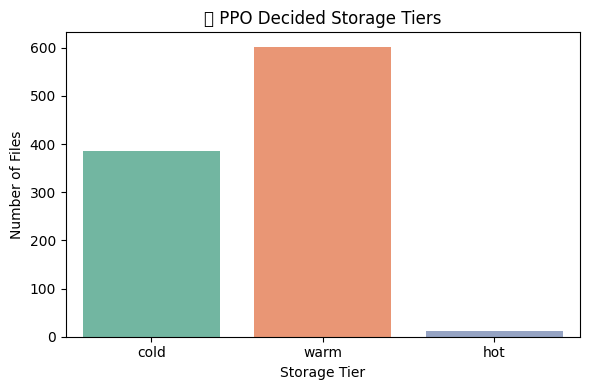

 Total storage cost with PPO tiering: ₹351.60


In [68]:
# PPO agent decides storage tier for each file
ppo_tiers = []
obs, _ = env.reset()

for _ in range(len(clean_df)):
    action, _ = model.predict(obs, deterministic=True)
    tier = {0: 'hot', 1: 'warm', 2: 'cold'}[int(action)]
    ppo_tiers.append(tier)

    obs, _, done, _, _ = env.step(action)
    if done:
        break

# Add decisions to dataframe
clean_df['ppo_tier'] = ppo_tiers

# Visualize the distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='ppo_tier', data=clean_df, palette='Set2')
plt.title("🔥 PPO Decided Storage Tiers")
plt.xlabel("Storage Tier")
plt.ylabel("Number of Files")
plt.tight_layout()
plt.show()

# Cost calculation
tier_cost = {'hot': 1.0, 'warm': 0.5, 'cold': 0.1}
ppo_cost = sum(clean_df['ppo_tier'].map(tier_cost))

print(f" Total storage cost with PPO tiering: ₹{ppo_cost:.2f}")
